In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from datetime import datetime
from pykalman import KalmanFilter

def to_timestamp(date):
    return date.timestamp()

def to_date(string):
    return datetime.strptime(string, '%Y-%m-%d %H:%M:%S.%f')

cpu_data = pd.read_csv("sysinfo.csv")
cpu_data

,timestamp,temperature,sys_load_1,cpu_percent,fan_rpm,cpu_freq
0,2018-05-10 00:00:34.102496,38,0.67,0.0819,693.0,1652.985500
1,2018-05-10 00:01:34.106931,38,0.59,0.0746,691.0,1751.238375
2,2018-05-10 00:02:34.111049,40,0.60,0.0564,699.0,1644.140375
3,2018-05-10 00:03:34.115387,40,0.61,0.0925,703.0,1827.442625
4,2018-05-10 00:04:34.119495,39,0.46,0.0794,694.0,1797.277125
...,...,...,...,...,...,...
2155,2018-05-11 11:55:42.894303,32,0.07,0.0125,624.0,2110.895750
2156,2018-05-11 11:56:42.897937,32,0.09,0.0125,624.0,1696.616750
2157,2018-05-11 11:57:42.901833,33,0.09,0.0136,625.0,1708.956500
2158,2018-05-11 11:58:42.905579,34,0.08,0.0150,629.0,1950.104125


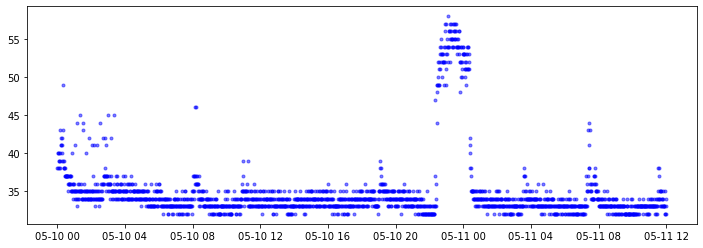

In [2]:
cpu_data['timestamp'] = cpu_data['timestamp'].apply(to_date)
plt.figure(figsize=(12, 4))
plt.plot(cpu_data['timestamp'], cpu_data['temperature'], 'b.', alpha=0.5)
plt.show()



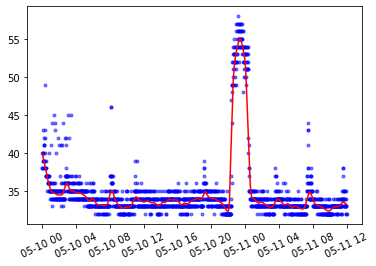

In [3]:

# cpu_data['timestamp_float'] = cpu_data['date'].apply(to_timestamp)
loess_smoothed = lowess(cpu_data['temperature'], cpu_data['timestamp'], frac=0.025)
plt.plot(cpu_data['timestamp'], cpu_data['temperature'], 'b.', alpha=0.5)
plt.plot(cpu_data['timestamp'], loess_smoothed[:,1], 'r-')
plt.xticks(rotation=25)
plt.show()

In [438]:
kalman_data = cpu_data[['temperature', 'cpu_percent', 'sys_load_1', 'fan_rpm']]

initial_state = kalman_data.iloc[0]
# observation_covariance = np.diag([0.1, 0.01, 0.1, 2]) ** 2 # TODO: shouldn't be zero
# transition_covariance = np.diag([0.01, 0.01, 0.3, 5]) ** 2 # TODO: shouldn't be zero
observation_covariance = np.diag([0.5, 0.3, 0.3, 5]) ** 2 
transition_covariance = np.diag([0.1, 0.1, 0.1, 5]) ** 2 
transition = [[0.96,0.5,0.2,-0.001], [0.1,0.4,2.3,0], [0,0,0.96,0], [0,0,0,1]] # TODO: shouldn't (all) be zero
kalman_data

,temperature,cpu_percent,sys_load_1,fan_rpm
0,38,0.0819,0.67,693.0
1,38,0.0746,0.59,691.0
2,40,0.0564,0.60,699.0
3,40,0.0925,0.61,703.0
4,39,0.0794,0.46,694.0
...,...,...,...,...
2155,32,0.0125,0.07,624.0
2156,32,0.0125,0.09,624.0
2157,33,0.0136,0.09,625.0
2158,34,0.0150,0.08,629.0


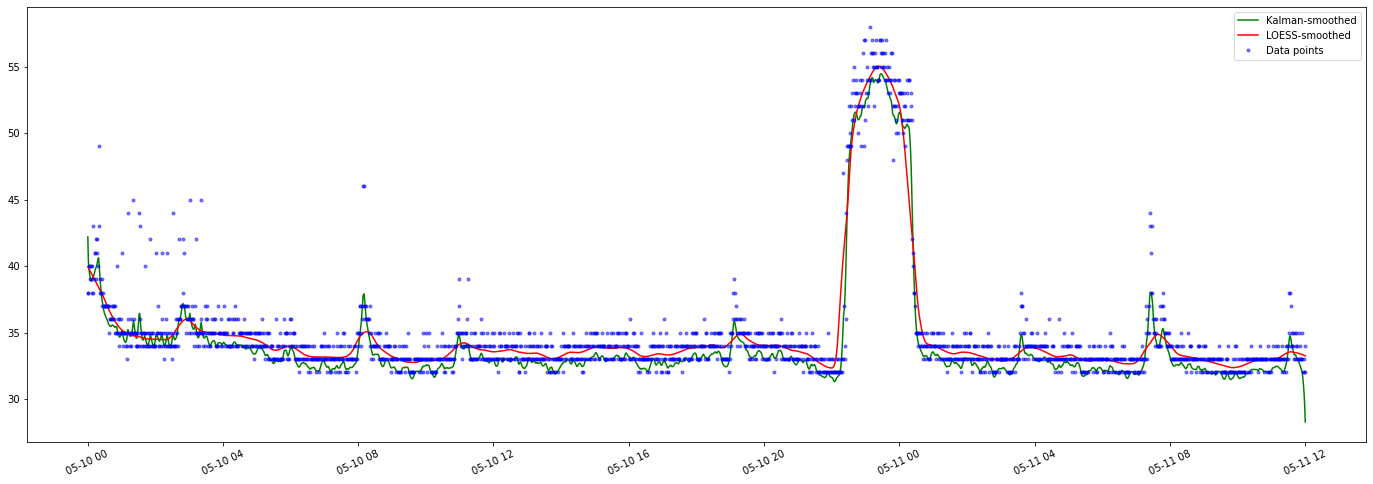

In [439]:
kf = KalmanFilter(
    initial_state_mean=initial_state,
    initial_state_covariance=observation_covariance,
    observation_covariance=observation_covariance,
    transition_covariance=transition_covariance,
    transition_matrices=transition
)
kalman_smoothed, _ = kf.smooth(kalman_data)
plt.figure(figsize=(24, 8))
plt.xticks(rotation=25)
plt.plot(cpu_data['timestamp'], kalman_smoothed[:, 0], 'g-')
plt.plot(cpu_data['timestamp'], loess_smoothed[:,1], 'r-')
plt.plot(cpu_data['timestamp'], cpu_data['temperature'], 'b.', alpha=0.5)
plt.legend(["Kalman-smoothed", 'LOESS-smoothed', 'Data points'])
